In [1]:
from dataset import getMNIST
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from lenet5.nn import ConvNeuralNet
from utils import getTorchDevice
import torch

plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
train_dataset, test_dataset, train_loader, test_loader = getMNIST(batch_size=64)

In [3]:
# device = getTorchDevice()
device = torch.device("cpu")
model = ConvNeuralNet(num_classes=10).to(device)
model.load("lenet5.pth")
device, model

(device(type='cpu'),
 ConvNeuralNet(
   (layer1): Sequential(
     (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (layer2): Sequential(
     (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
     (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU()
     (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   )
   (fc): Linear(in_features=400, out_features=120, bias=True)
   (relu): ReLU()
   (fc1): Linear(in_features=120, out_features=84, bias=True)
   (relu1): ReLU()
   (fc2): Linear(in_features=84, out_features=10, bias=True)
 ))

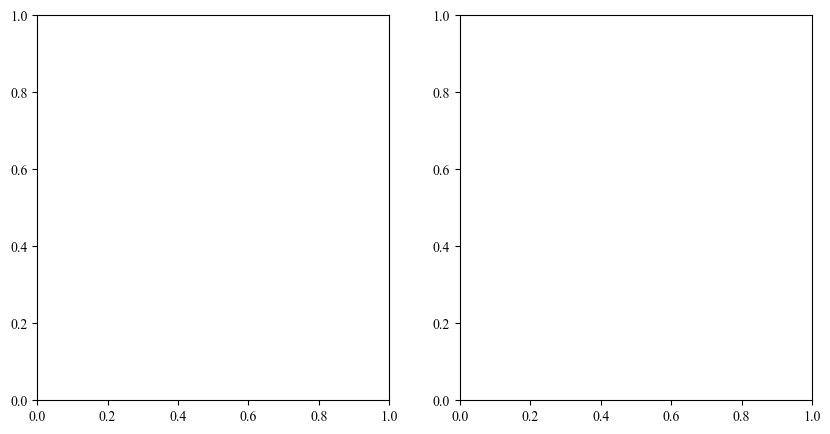

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

In [5]:
import time
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import F1Score, Recall, Precision, ConfusionMatrix
from torchmetrics.classification import MultilabelAccuracy, Accuracy
def testFullLENET5(model, test_loader):
    model.disableHDC()
    y_true = []
    y_pred = []
    times = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            st = time.time()
            
            outputs = model(images)
            et = time.time()
            times.append(et - st)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

        print('Accuracy of the network on the 10000 test images: {} %'.format(
            100 * correct / total))
    y_true = torch.from_numpy(np.array(y_true))
    y_pred = torch.from_numpy(np.array(y_pred))
    f1 = F1Score(task="multiclass", num_classes=10)
    print("F1",  f1(y_pred, y_true))

    recall = Recall(task="multiclass", average='macro', num_classes=10)
    print("Recall",  recall(y_pred, y_true))

    precision = Precision(task="multiclass", average='macro', num_classes=10)
    print("Precision",  precision(y_pred, y_true))

    accuracy = Accuracy(num_classes=10, task="multiclass", average='none')
    print("Accuracy",  accuracy(y_pred, y_true))
    accuracy = Accuracy(num_classes=10, task="multiclass", average='macro')
    print("Accuracy",  accuracy(y_pred, y_true))

    confusionMatrix = ConfusionMatrix(num_classes=10, task="multiclass")
    confusionMatrix = confusionMatrix(y_pred, y_true)
    # print(confusionMatrix(y_pred, y_true))
    
    im = ax1.imshow(confusionMatrix, cmap='bwr')
    for (j,i),label in np.ndenumerate(confusionMatrix):
        if(label < 500):
            ax1.text(i,j,label,ha='center',va='center', color='white')
        else:
            ax1.text(i,j,label,ha='center',va='center', color='black')
    # plt.imshow(confusionMatrix(y_pred, y_true).cpu().numpy(), cmap='bwr')
    print("Number of shots:", len(y_true))
    ax1.set_title("LeNet5 CNN")

    # return et - st + 0.0014649101257324219, 
    return times
lenet_execution_time = testFullLENET5(model, test_loader)
print('Execution time (Full LENET5):',lenet_execution_time , 'seconds, for device:', device)

Accuracy of the network on the 10000 test images: 98.76 %
F1 tensor(0.9876)
Recall tensor(0.9875)
Precision tensor(0.9877)
Accuracy tensor([0.9888, 0.9938, 0.9981, 0.9911, 0.9654, 0.9910, 0.9812, 0.9786, 0.9918,
        0.9950])
Accuracy tensor(0.9875)
Number of shots: 10000
Execution time (Full LENET5): [0.003570079803466797, 0.0030891895294189453, 0.0029408931732177734, 0.0028619766235351562, 0.002753019332885742, 0.0028600692749023438, 0.00284576416015625, 0.0030548572540283203, 0.0029501914978027344, 0.002830028533935547, 0.0029921531677246094, 0.002808094024658203, 0.0029850006103515625, 0.003002166748046875, 0.0028839111328125, 0.0027740001678466797, 0.0031707286834716797, 0.002900838851928711, 0.0029418468475341797, 0.002847909927368164, 0.0027599334716796875, 0.0029790401458740234, 0.003111124038696289, 0.0030918121337890625, 0.002973794937133789, 0.002675771713256836, 0.0030450820922851562, 0.0029211044311523438, 0.003052234649658203, 0.002952098846435547, 0.002845048904418945

In [6]:
hvsDict = {
    "0": [],
    "1": [],
    "2": [],
    "3": [],
    "4": [],
    "5": [],
    "6": [],
    "7": [],
    "8": [],
    "9": [],

}
with torch.no_grad():
    model.HDCMode = True
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        outputs = outputs > 0.5
        for idx, label in enumerate(labels):
            hvsDict[str(label.item())].append(np.array(outputs[idx]))

In [7]:
profile_vectors = []
for i in range(10):
    hvs = np.swapaxes(np.array(hvsDict[str(i)]), 1,0)
    middle = hvs.shape[1] / 2
    hvs = np.sum(hvs, axis=1)

    profile_vector = hvs >  middle
    profile_vectors.append(profile_vector)
np.array(profile_vectors)

array([[False,  True,  True, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False]])

In [8]:
def hammingDistance(a, b):
    return np.count_nonzero(a!=b)
def batchedHDC(input):
    input = input > 0.5
    similarities = []
    for i in range(input.shape[0]):
        similarities.append(np.array([hammingDistance(np.array(input[i]), np.array(profile_vector)) for profile_vector in profile_vectors]))
    similarities = np.array(similarities)
    return np.argmin(similarities, axis=1)

def testHDC(model, test_loader):
    model.enableHDC()
    y_true = []
    y_pred = []
    times = []
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            st = time.time()
            outputs = model(images)  ## output of "middle" layer
            predicted = batchedHDC(outputs)
            et = time.time()
            times.append(et - st)
            total += labels.size(0)
            correct += (predicted == np.array(labels)).sum().item()
            y_true.extend(labels)
            y_pred.extend(predicted)
        y_true = torch.from_numpy(np.array(y_true))
        y_pred = torch.from_numpy(np.array(y_pred))
        f1 = F1Score(task="multiclass", num_classes=10)
        print("F1",  f1(y_pred, y_true))

        recall = Recall(task="multiclass", average='macro', num_classes=10)
        print("Recall",  recall(y_pred, y_true))

        precision = Precision(task="multiclass", average='macro', num_classes=10)
        print("Precision",  precision(y_pred, y_true))

        accuracy = Accuracy(num_classes=10, task="multiclass", average='none')
        print("Accuracy",  accuracy(y_pred, y_true))
        accuracy = Accuracy(num_classes=10, task="multiclass", average='macro')
        print("Accuracy",  accuracy(y_pred, y_true))
        confusionMatrix = ConfusionMatrix(num_classes=10, task="multiclass")
        confusionMatrix = confusionMatrix(y_pred, y_true)
        # # print(confusionMatrix(y_pred, y_true))
        
        # im = ax2.imshow(confusionMatrix, cmap='bwr')
        # for (j,i),label in np.ndenumerate(confusionMatrix):
        #     if(label < 500):
        #         ax2.text(i,j,label,ha='center',va='center', color='white')
        #     else:
        #         ax2.text(i,j,label,ha='center',va='center', color='black')
        print("Number of shots:", len(y_true))
        ax2.set_title("CNN-HDC")
    return times

hdc_execution_time = testHDC(model, test_loader)
print('Execution time (HDC):',hdc_execution_time , 'seconds, for device:', device)

F1 tensor(0.9286)
Recall tensor(0.9277)
Precision tensor(0.9314)
Accuracy tensor([0.9806, 0.9947, 0.8847, 0.9337, 0.9196, 0.8991, 0.9572, 0.8911, 0.8809,
        0.9356])
Accuracy tensor(0.9277)
Number of shots: 10000
Execution time (HDC): [0.006374359130859375, 0.0060007572174072266, 0.005767822265625, 0.00568699836730957, 0.00570225715637207, 0.005934715270996094, 0.00560307502746582, 0.005773067474365234, 0.005856037139892578, 0.0056819915771484375, 0.0060122013092041016, 0.005712985992431641, 0.005576372146606445, 0.005632162094116211, 0.005841255187988281, 0.005952596664428711, 0.006132841110229492, 0.0063779354095458984, 0.006381034851074219, 0.005977153778076172, 0.006444215774536133, 0.006414175033569336, 0.00599980354309082, 0.006065845489501953, 0.00661015510559082, 0.005941152572631836, 0.006382942199707031, 0.006120920181274414, 0.006249904632568359, 0.006452083587646484, 0.009241819381713867, 0.008681297302246094, 0.010657072067260742, 0.009301900863647461, 0.0062170028686

In [9]:
print('Speedup:', lenet_execution_time / hdc_execution_time)


hdc_execution_time, lenet_execution_time

TypeError: unsupported operand type(s) for /: 'list' and 'list'

In [ ]:
from torchviz import make_dot

In [10]:

# model.disableHDC()
# for images, labels in test_loader:
#     images = images.to(device)
#     labels = labels.to(device)
#     outputs = model(images)



# make_dot(outputs, params=dict(list(model.named_parameters()))).render("full-lenet-diagram", format="pdf")

In [11]:

# model.enableHDC()
# for images, labels in test_loader:
#     images = images.to(device)
#     labels = labels.to(device)
#     outputs = model(images)



# make_dot(outputs, params=dict(list(model.named_parameters()))).render("hdc-lenet-diagram", format="pdf")

In [12]:
# fig.suptitle('Confusion Matrices')
# fig.savefig('confusion-matrices.pdf')

In [14]:
import torch.utils.data as data_utils
from torch.utils.data import DataLoader

lengths = np.linspace(1000, 10000, 10, dtype=int)

hdc_times = []
lenet_times = []
for number_of_images in lengths:
    subset = torch.utils.data.random_split(test_dataset, [number_of_images, len(test_dataset)-number_of_images])[0]

    sub_loader = torch.utils.data.DataLoader(dataset=subset,
                                              batch_size=64,
                                              shuffle=True)
    lenet_execution_time = testFullLENET5(model, sub_loader)
    hdc_execution_time = testHDC(model, sub_loader)
    hdc_times.append(np.array(hdc_execution_time).sum())
    lenet_times.append(np.array(lenet_execution_time).sum())

Accuracy of the network on the 10000 test images: 98.5 %
F1 tensor(0.9850)
Recall tensor(0.9846)
Precision tensor(0.9843)
Accuracy tensor([0.9703, 1.0000, 0.9902, 1.0000, 0.9468, 0.9898, 0.9811, 0.9912, 1.0000,
        0.9770])
Accuracy tensor(0.9846)
Number of shots: 1000
F1 tensor(0.9290)
Recall tensor(0.9282)
Precision tensor(0.9318)
Accuracy tensor([0.9703, 1.0000, 0.8431, 0.9596, 0.9149, 0.8980, 0.9434, 0.9204, 0.8556,
        0.9770])
Accuracy tensor(0.9282)
Number of shots: 1000
Accuracy of the network on the 10000 test images: 99.2 %
F1 tensor(0.9920)
Recall tensor(0.9920)
Precision tensor(0.9918)
Accuracy tensor([0.9800, 0.9913, 0.9959, 0.9953, 0.9679, 1.0000, 0.9947, 0.9951, 1.0000,
        1.0000])
Accuracy tensor(0.9920)
Number of shots: 2000
F1 tensor(0.9365)
Recall tensor(0.9361)
Precision tensor(0.9375)
Accuracy tensor([0.9900, 0.9913, 0.8884, 0.9296, 0.9305, 0.9326, 0.9734, 0.9113, 0.8728,
        0.9409])
Accuracy tensor(0.9361)
Number of shots: 2000
Accuracy of the ne

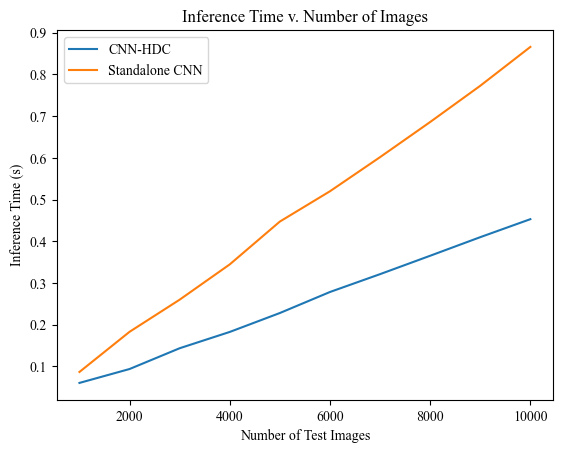

In [22]:

plt.plot(lengths, lenet_times, label="CNN-HDC")
plt.plot(lengths, hdc_times, label="Standalone CNN")
plt.legend()
plt.xlabel("Number of Test Images")
plt.ylabel("Inference Time (s)")
plt.title("Inference Time v. Number of Images")
plt.savefig("inference-time.pdf")
plt.show()

In [21]:
print("Lenet5 Inference Times:", lenet_times)
print("HDC Inference Times:", hdc_times)
print("Number of Images", lengths)

Lenet5 Inference Times: [0.06052374839782715, 0.09384560585021973, 0.143632173538208, 0.18270492553710938, 0.22806000709533691, 0.27843546867370605, 0.32120394706726074, 0.365293025970459, 0.40984344482421875, 0.45295047760009766]
HDC Inference Times: [0.08679008483886719, 0.18301820755004883, 0.2600288391113281, 0.3446006774902344, 0.44722986221313477, 0.519852876663208, 0.6016104221343994, 0.6858170032501221, 0.7726736068725586, 0.8657751083374023]
Number of Images [ 1000  2000  3000  4000  5000  6000  7000  8000  9000 10000]
